In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta
from utilsforecast.losses import mae, mape, rmse  

In [165]:
df = pd.read_csv(r"C:\Users\Nav\Documents\BaggageRevenueModel\BaggageRevenueModel\data\combined_bag_revenue.csv")
df.head()

,Airline,2015-Q1,2015-Q2,2015-Q3,2015-Q4,2016-Q1,2016-Q2,2016-Q3,2016-Q4,2017-Q1,...,2022-Q3,2022-Q4,2023-Q1,2023-Q2,2023-Q3,2023-Q4,2024-Q1,2024-Q2,2024-Q3,2024-Q4
0,Alaska,23686.0,30215.0,34127.0,24787.0,30484.0,35022.0,39297.0,30811.0,30602.0,...,92981.0,80917.0,74482.0,97943.0,101337.0,84549.0,83934.0,106033.0,118372.0,98236.0
1,Allegiant,40444.0,42463.0,39934.0,38523.0,43759.0,45934.0,45168.0,42468.0,46556.0,...,83634.0,80586.0,88685.0,96696.0,86787.0,85386.0,90754.0,101292.0,90031.0,89385.0
2,American,151758.0,165660.0,292089.0,267293.0,262464.0,288836.0,288124.0,278048.0,272805.0,...,351356.0,348944.0,325296.0,352279.0,342047.0,337299.0,334743.0,394435.0,389782.0,382369.0
3,Delta,198119.0,226294.0,236890.0,213799.0,197690.0,232461.0,228971.0,213297.0,203507.0,...,252159.0,234831.0,226255.0,253222.0,259462.0,246286.0,239012.0,289749.0,259227.0,272113.0
4,Frontier,42011.0,49565.0,56582.0,71886.0,70755.0,71578.0,84962.0,79497.0,80224.0,...,201770.0,222968.0,221438.0,231463.0,211176.0,215842.0,203624.0,233695.0,212662.0,211643.0


In [166]:
# Reshape data for statsforecast

df_long = df.melt(id_vars=['Airline'], var_name='Quarter', value_name="Baggage Revenue")
df_long['Quarter'] = pd.PeriodIndex(df_long['Quarter'], freq='Q').to_timestamp(how="end")
df_long = df_long.rename(columns={"Airline": "unique_id", "Baggage Revenue": "y"})

# Final columns should be ['unique_id', 'ds', 'y']
df_long = df_long[['unique_id', 'Quarter', 'y']].rename(columns={"Quarter": "ds"})
df_long

,unique_id,ds,y
0,Alaska,2015-03-31 23:59:59.999999999,23686.0
1,Allegiant,2015-03-31 23:59:59.999999999,40444.0
2,American,2015-03-31 23:59:59.999999999,151758.0
3,Delta,2015-03-31 23:59:59.999999999,198119.0
4,Frontier,2015-03-31 23:59:59.999999999,42011.0
...,...,...,...
435,JetBlue,2024-12-31 23:59:59.999999999,143084.0
436,Southwest,2024-12-31 23:59:59.999999999,20956.0
437,Spirit,2024-12-31 23:59:59.999999999,123925.0
438,Sun Country,2024-12-31 23:59:59.999999999,25469.0


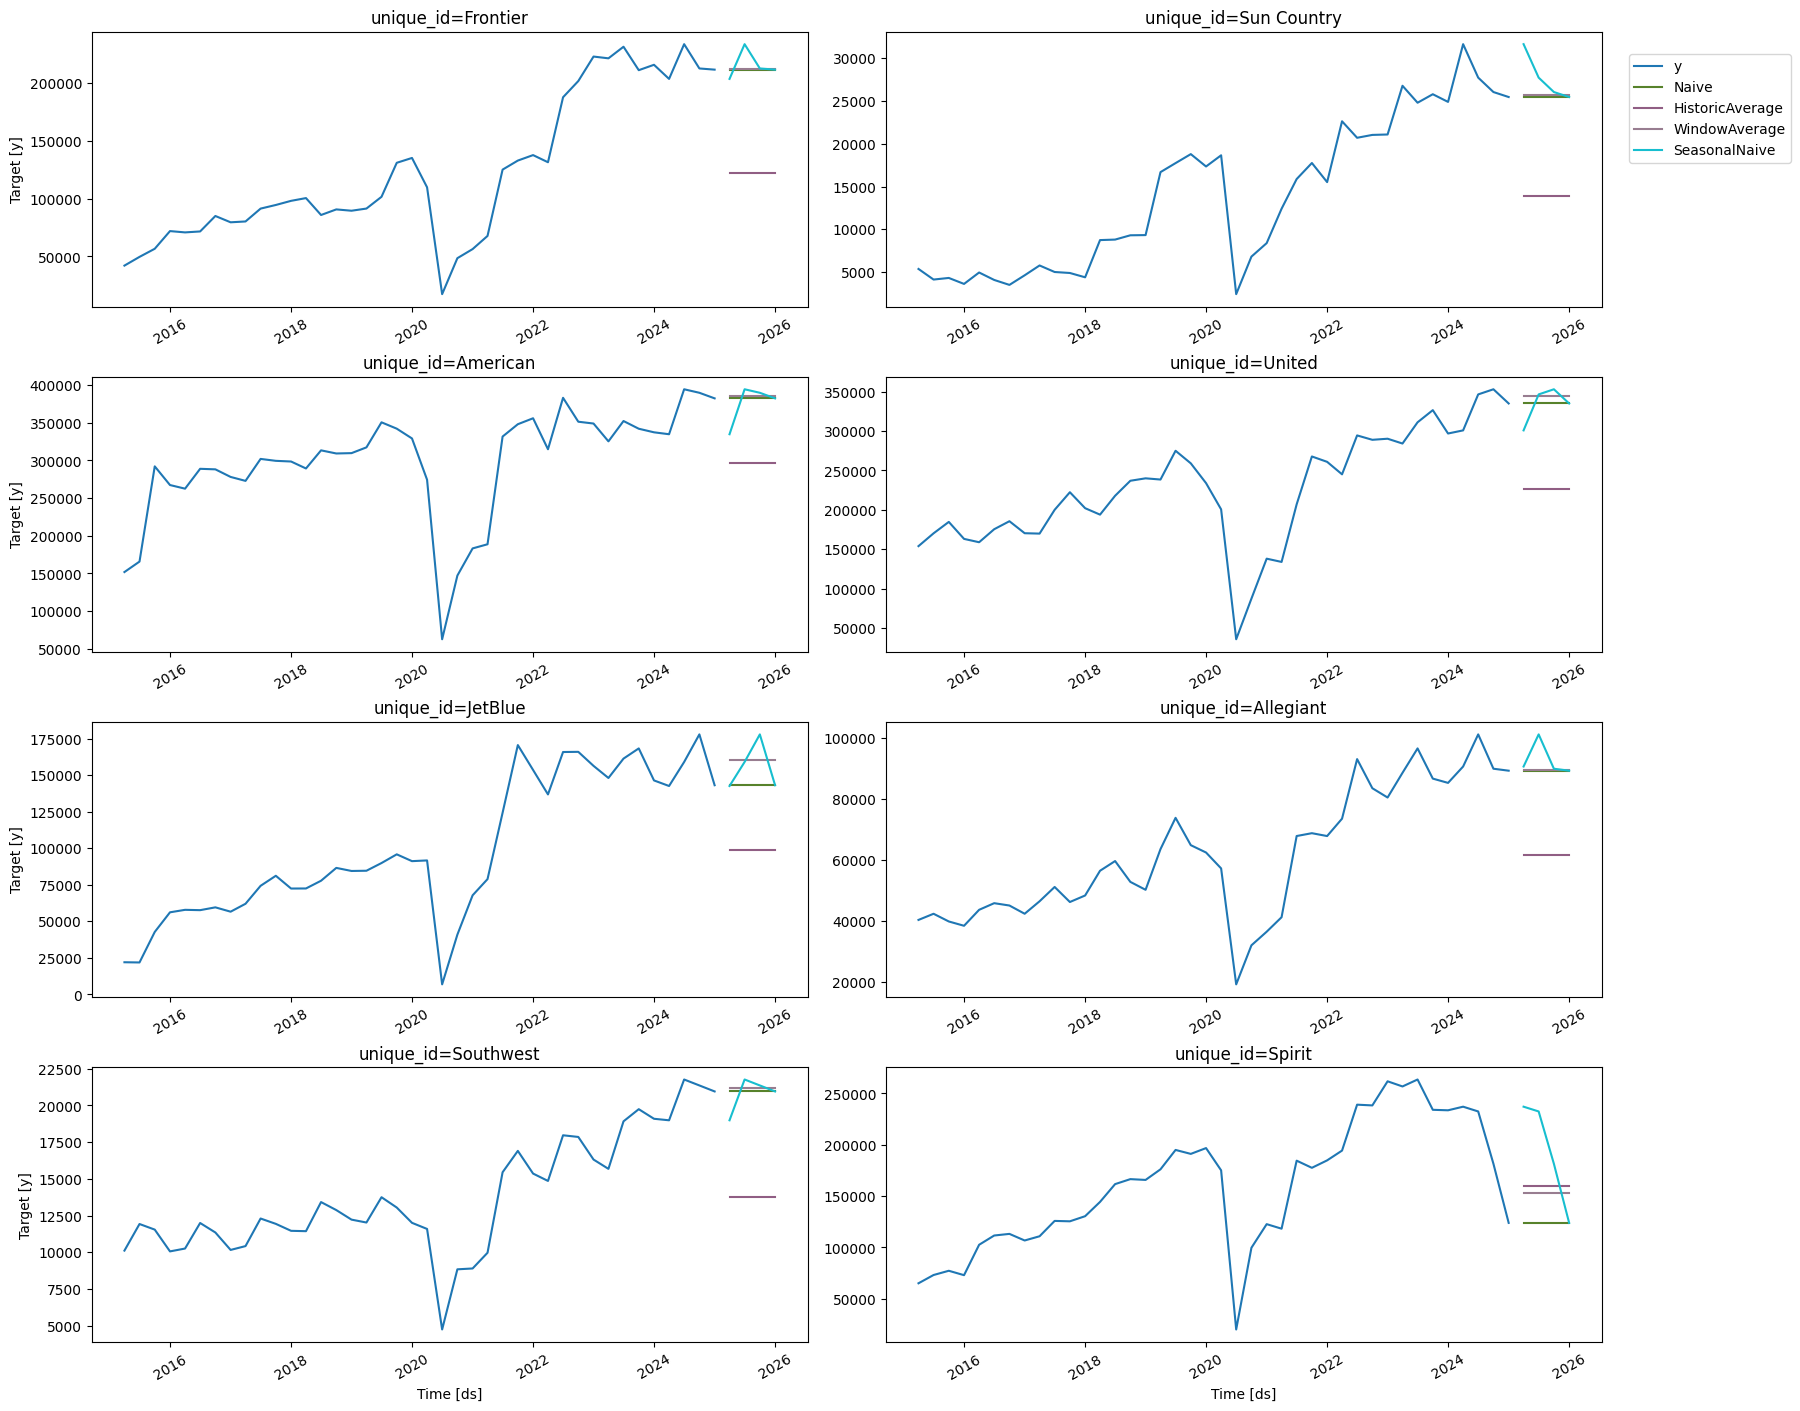

In [167]:
# Baseline models
horizon = 4 # forecasting a year ahead

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=2),
    SeasonalNaive(season_length=4)
]

sf = StatsForecast(models=models, freq='QE')
sf.fit(df=df_long)
preds = sf.predict(h=horizon)
preds.head()
plot_series(df=df_long, forecasts_df=preds)

In [168]:
# Evaluation of Baseline Models

test = df_long.groupby('unique_id').tail(horizon)
train = df_long.drop(test.index).reset_index(drop=True)

In [169]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['unique_id', 'ds'])

In [170]:
evaluation = evaluate( df=eval_df, metrics=[mae, mape, rmse] )
evaluation

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,Alaska,mae,17402.250000,43382.583333,13205.250000,12066.000000
1,Allegiant,mae,7479.500000,34643.222222,6779.000000,3477.000000
2,American,mae,39311.250000,87162.000000,38124.250000,36102.000000
3,Delta,mae,22376.250000,49543.222222,19082.250000,18836.500000
4,Frontier,mae,9362.500000,103303.666667,8196.000000,6432.750000
5,Hawaiian,mae,4394.750000,3617.611111,3598.500000,3298.500000
6,JetBlue,mae,12802.000000,63124.444444,12802.000000,5167.000000
7,Southwest,mae,1728.250000,7812.888889,1564.750000,2409.750000
8,Spirit,mae,41569.750000,53716.250000,41689.000000,53228.000000
9,Sun Country,mae,2829.250000,15313.138889,2380.250000,2156.500000


In [171]:
# ARIMA and SARIMA Models

unique_ids = df_long["unique_id"].unique().tolist()
small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]


models = [
    AutoARIMA(season_length=1, max_p=6, max_q=6, max_P=3, max_Q=3, alias="ARIMA"),
    AutoARIMA(season_length=4, max_p=6, max_q=6, max_P=3, max_Q=3, alias="SARIMA"),
    AutoETS(season_length=4, alias="ETS"),
    AutoTheta(season_length=4, alias="Theta"),
]

sf = StatsForecast(models=models, freq='QE')
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(test, arima_preds, 'left', ['ds', 'unique_id'])
arima_eval = evaluate( df=arima_eval_df, metrics=[mae] )
arima_eval

,unique_id,metric,ARIMA,SARIMA,ETS,Theta
0,Alaska,mae,17402.250000,17402.250000,9723.041315,15598.531205
1,Allegiant,mae,7479.500000,7479.500000,7427.164113,4809.304075
2,American,mae,68230.973325,68230.973325,39122.730963,34617.367831
3,Delta,mae,45914.367750,45914.367750,22375.591231,21867.571149
4,Frontier,mae,9362.500000,9362.500000,21434.527621,15690.593104
5,Hawaiian,mae,4313.153118,4313.153118,4394.508097,4488.851952
6,JetBlue,mae,12802.000000,12802.000000,17934.763903,12802.000000
7,Southwest,mae,1728.250000,1728.250000,1691.882940,1261.258478
8,Spirit,mae,41569.750000,41569.750000,67410.103729,54607.195972
9,Sun Country,mae,2829.250000,2829.250000,2041.486943,2608.117502


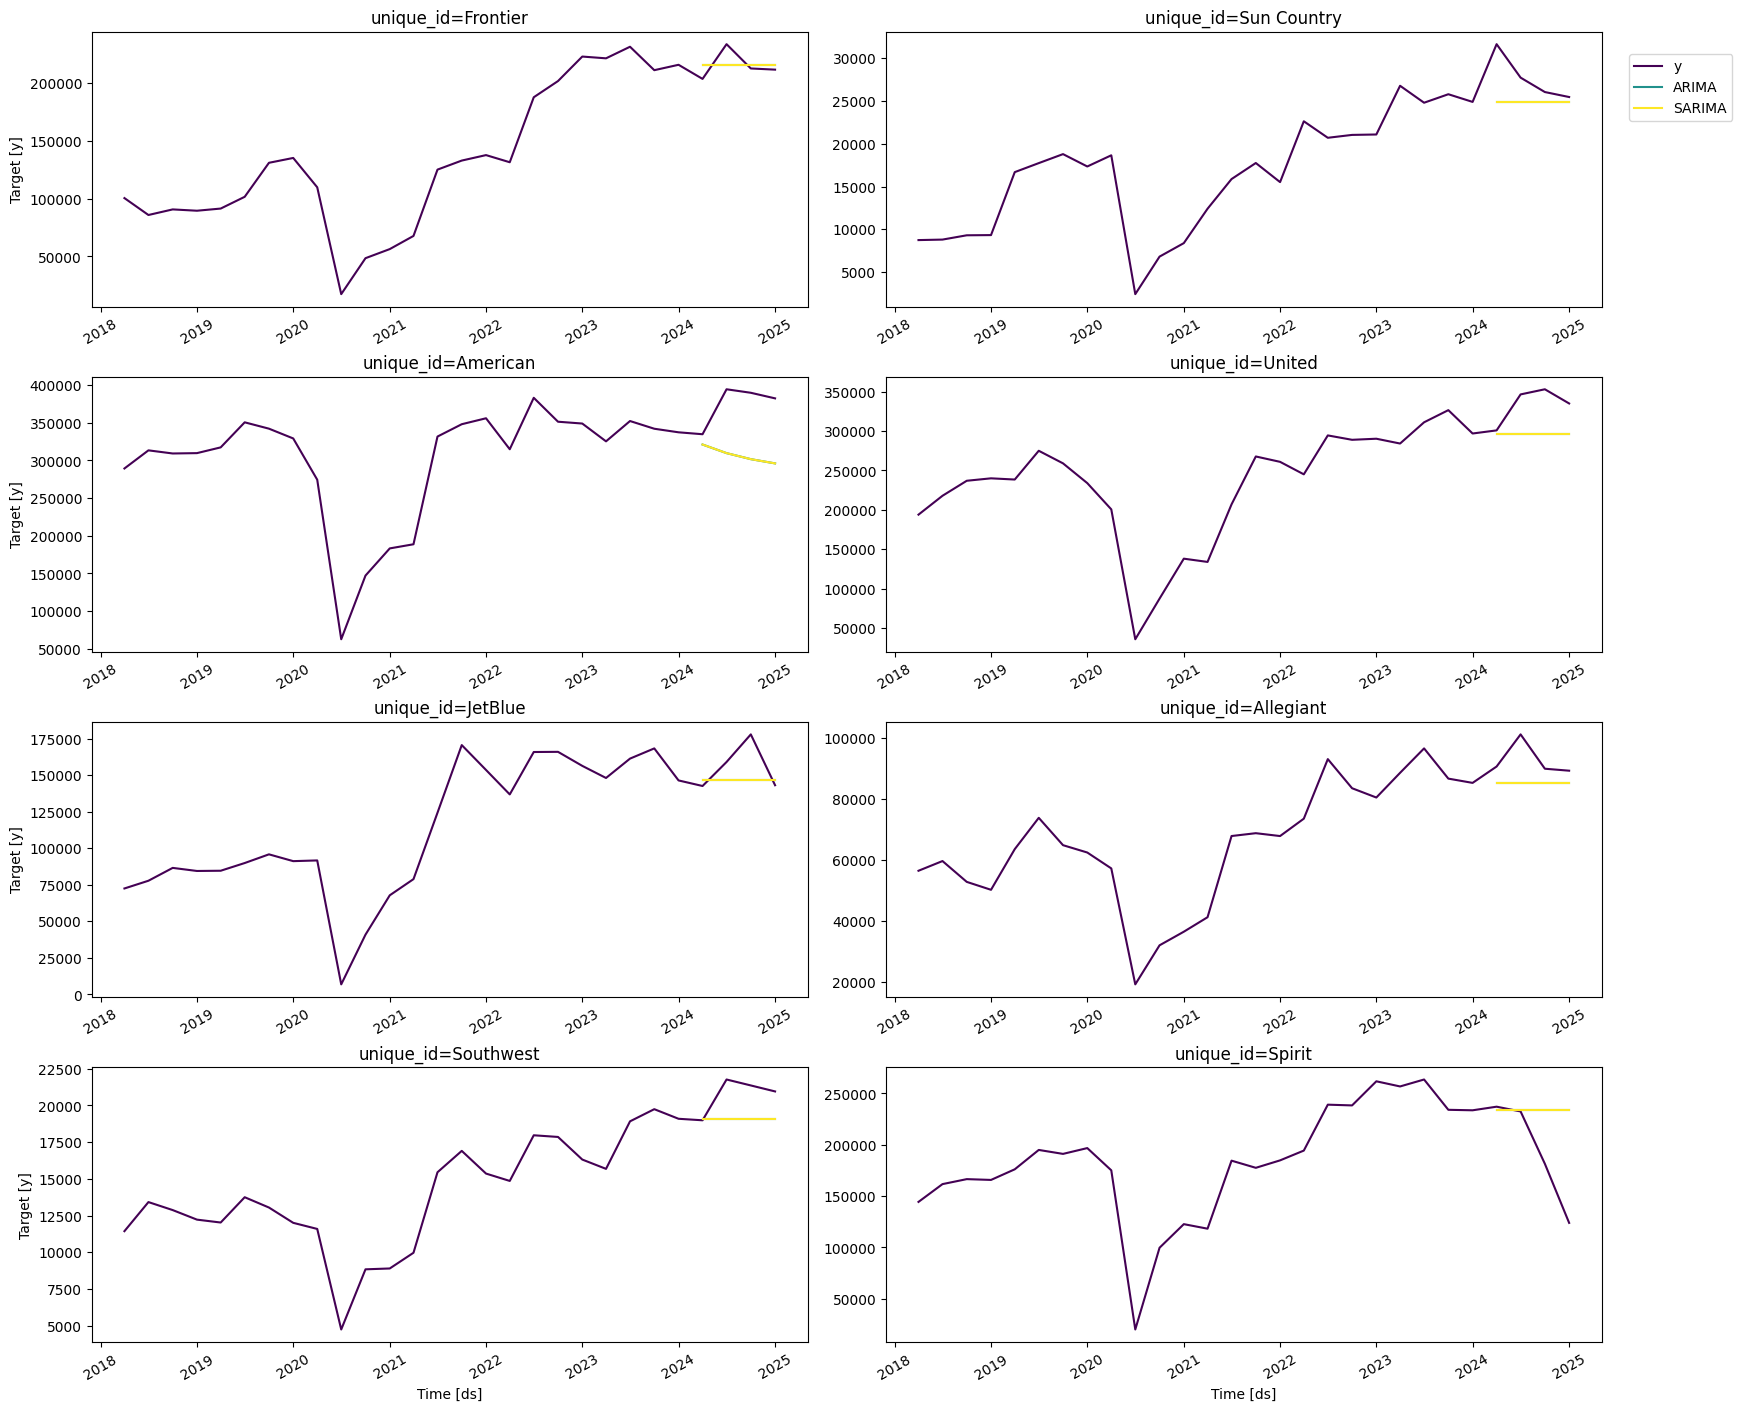

In [172]:
# plotting

ids_to_show = df_long['unique_id'].unique().tolist()
arima_plot = arima_preds[["unique_id","ds","ARIMA","SARIMA"]]

# Make the plot
plot_series(
    df=df_long,                          
    forecasts_df=arima_plot,       
    ids=ids_to_show,          
    max_insample_length=28,    
    palette="viridis"
)

In [173]:
## Cross-Validation
small_df = df_long[df_long["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=4),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=4, alias="SARIMA")
]

sf = StatsForecast(models=models,  freq="QE")
cv_df = sf.cross_validation(
    h=horizon,
    df=df_long,
    n_windows=4,
    step_size=horizon,
    refit=True
)

cv_df

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,Alaska,2021-03-31 23:59:59.999999999,2020-12-31 23:59:59.999999999,39761.0,63687.0,42715.000000,42715.000000
1,Alaska,2021-06-30 23:59:59.999999999,2020-12-31 23:59:59.999999999,62587.0,22614.0,42715.000000,42715.000000
2,Alaska,2021-09-30 23:59:59.999999999,2020-12-31 23:59:59.999999999,71000.0,38323.0,42715.000000,42715.000000
3,Alaska,2021-12-31 23:59:59.999999999,2020-12-31 23:59:59.999999999,68825.0,42715.0,42715.000000,42715.000000
4,Alaska,2022-03-31 23:59:59.999999999,2021-12-31 23:59:59.999999999,64370.0,39761.0,68825.000000,68825.000000
...,...,...,...,...,...,...,...
171,United,2023-12-31 23:59:59.999999999,2022-12-31 23:59:59.999999999,296843.0,290224.0,233074.954938,233074.954938
172,United,2024-03-31 23:59:59.999999999,2023-12-31 23:59:59.999999999,300800.0,284126.0,296843.000000,296843.000000
173,United,2024-06-30 23:59:59.999999999,2023-12-31 23:59:59.999999999,346431.0,311057.0,296843.000000,296843.000000
174,United,2024-09-30 23:59:59.999999999,2023-12-31 23:59:59.999999999,352933.0,326473.0,296843.000000,296843.000000


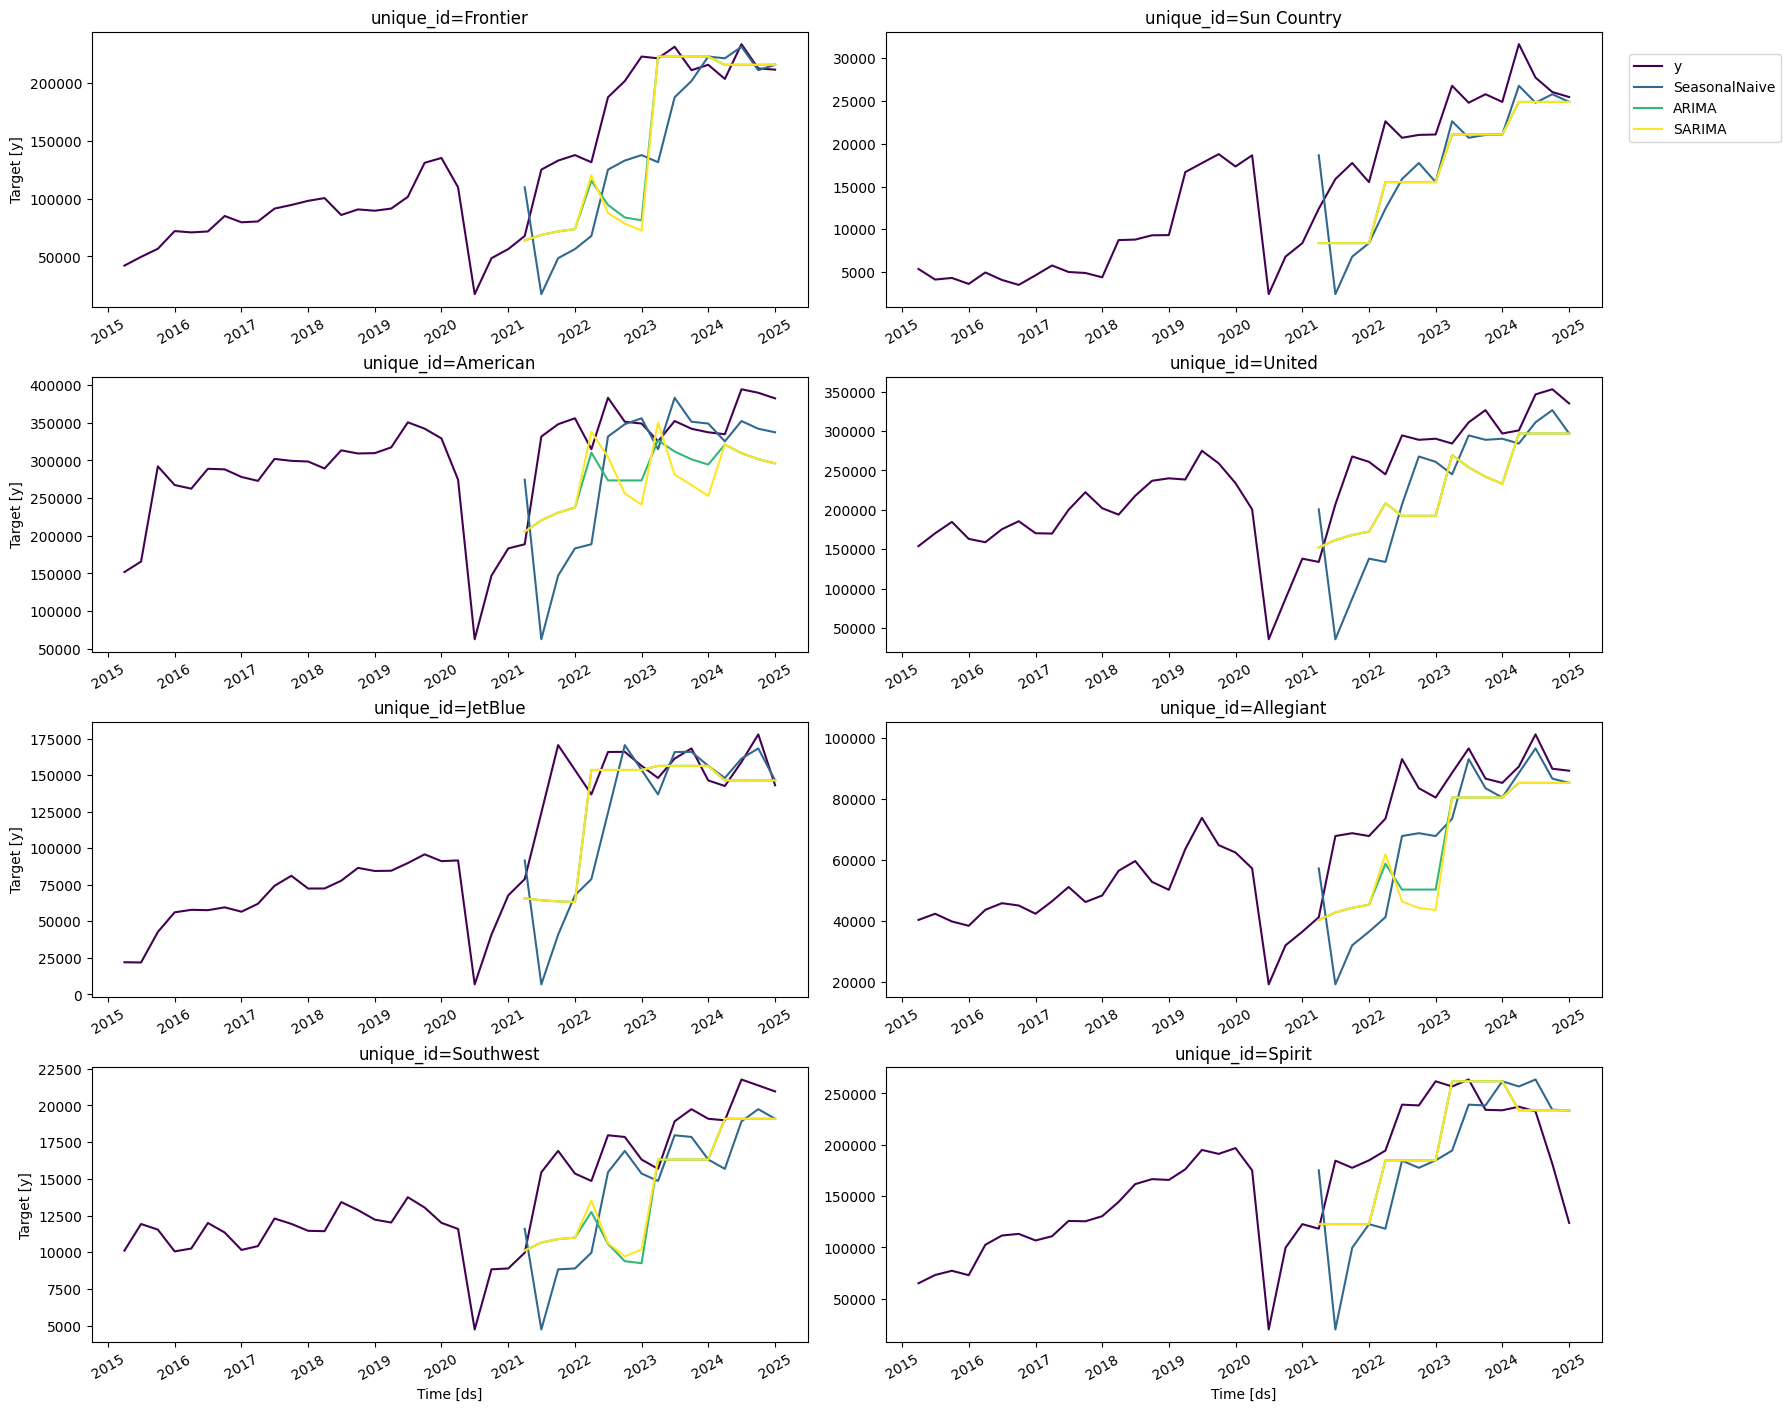

In [174]:
ids_to_show = df_long['unique_id'].unique().tolist()
arima_plot = arima_preds[["unique_id","ds","ARIMA","SARIMA"]]

# Make the plot
plot_series(
    df=small_df,                          
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),      
    ids=ids_to_show,          
    max_insample_length=40,    
    palette="viridis"
)